In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [147]:
TICKSIZE = 15
TITLESIZE = 25

# Damage per Round - Einleitung

Zwei Punkte, die den Schaden pro Runde beeinflussen:
1. Trefferwahrscheinlichkeit
2. Waffenschaden (Damage Die + Bonus)
3. (Crits)

Kritische treffer sind eigentlich kein eigener Punkt, vielmehr sind Crits genauso eine Kombination aus Damage und Wahrscheinlichkeit.

## Trefferwahrscheinlichkeit?
Zuerst die regeltechnischen Rahmenbedingungen
* In D&D wird ein Treffer mit einem 20-seitigen Würfel ermittelt.
* Zu dem Würfelresultat wird der toHit-Bonus (Ability Modifier + Proficiency Bonus) hinzugezählt.
* Die ermittelte Zahl wird mit der Armour Class (AC) des Monsters verglichen.
    * Ist die Zahl größer, oder gleichgroß wie die AC des Monsters ("meets it beats it"), ist das ein Treffer.
    * Z.B. Bei einer AC von 13 und einem +3 toHit-Bonus muss ich 10 und höher würfeln.
* Trefferwahrscheinlichkeit ist also die Wahrscheinlichkeit über einem gewissen Wert zu liegen

### Statistische Bemerkungen zur Trefferwahrscheinlichkeit
* Es gibt insgesamt 20 mögliche Kombinationen auf einem d20.
    * Jede Zahl steht für 5%ige Wahrscheinlichkeit.
* Wenn nun alles unter 10 ein Misserfolg wäre, kann man auch sagen:
    * Die AC des Monsters minus toHit Modifier ergibt die niedrigste Zahl, die noch trifft (=Mein gewünschtes Resultat).
    * 1 weniger als mein gewünschtes Resultat ergibt die höchste Zahl, die nicht trifft.
        * In unserem Fall: 9.
* Also ist die Wahrscheinlichkeit mit einem +3 toHit-Bonus eine AC 13 nicht zu treffen 9/20, oder 0,45.
    * Bzw. im Umkehrschluss: in 11 von 20 Fällen treffen wir, oder: wir haben eine 55%ige Wahrscheinlichkeit zu treffen.
    * $\frac{11}{20}=0,55=55\%$

$Trefferwahrscheinlichkeit = 1 - \frac{(Benötigtes Ergebnis) -1}{20}$

In [148]:
toHit_prob = pd.DataFrame(index=list(range(2,21)))
toHit_prob.index.name = "Benötigtes Ergebnis"
toHit_prob["Trefferwahrscheinlichkeit"] = 1-(toHit_prob.index-1)/20
toHit_prob.transpose()

Benötigtes Ergebnis,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Trefferwahrscheinlichkeit,0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.55,0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,0.05


## Waffenschaden

Der reine Schaden, der diese Waffe macht. In DnD haben wir 6 unterschiedliche Schadenswürfel:

* d4, d6, d8, d10, d12, 2d6

### Durchschnittlicher Schaden

Der durchschnittliche Wert eines Würfels ist immer die Hälfte der maximalen Würfelzahl ($d_{max}$) +0.5

$\bar{x} = \frac{d_{max}}{2}+0,5$

Das durchschnittliche Würfelergebnis eines d4 ist 2,5.

$\hat{x} = \frac{1+2+3+4}{4} = \frac{10}{4} = 2,5$

Gleiches gilt für jeden Würfel.
* d6 = 3,5
* d8 = 4,5
* d10 = 5,5
* d12 = 6,5
* 2d6 = 7

## Zu erwartender Schaden

Der durchschnittliche Schaden einer Waffe wäre erreicht, wenn man bei unendlich vielen Versuchen zu 100% trifft.

Da das nicht der Fall ist, muss der durchschnittliche Schaden mit der Trefferwahrscheinlichkeit modifiziert werden, um den zu erwartenden Schaden zu ergeben.

$\mu= Trefferwahrscheinlichkeit*\hat{Würfelergebnis}$

### Beispiel

Man kann nun sagen, dass wenn ich mit einer Waffe:
* die durchschnittlich 3,5 Schaden macht (d6)
* in 55% der Fälle meinen Gegner treffe (10 und darüber trifft)
* dann kann ich erwarten, mit jedem Angriff 1,925 Punkte Schaden mache.

$3,5*0,55 = 1,925$



## Was ist mit den Crits?

Mit kritischen Treffern verhält es sich genau gleich und die Mechanik wird in den zu erwartenden Schaden miteingerechnet.

* Die Chance auf einen Crit ist (normalerweise) 5% (20 auf einem d20)
* Die Würfelanzahl wird verdoppelt (1d6 --> 2d6)

$\bar{x}_{crit} = 2*(\frac{d_{max}}{2}+0,5)$

* Der kritische Schaden eines d6 ist daher $7$.
* Bei einem Greatsword (2d6) ist der kritische Schaden: $14$


### Beispiel
* Kritischer Schaden: 1d6
* Crit-Wahrscheinlichkeit = 0,05

$7*0,05=0,35$

* Diese 0,35 werden nun zu dem "normalen" erwartenden Schaden addiert (s.o. 1,925).

$1,925+0,35=2,275$

* Somit ist der tatsächlich zu erwartende Schaden 2,275

In [149]:
class Dice:
    def __init__(self, minRoll, maxRoll):
        self.name = "d{}".format(maxRoll)
        self.minRoll = minRoll
        self.maxRoll = maxRoll
        self.dice = np.arange(minRoll,maxRoll+1)
    def calcDiceMean(self):
        diceMean = self.dice.mean()
        return diceMean
    

dice_dictionary = {
    "d2":Dice(1,2),
    "d4":Dice(1,4),
    "d6":Dice(1,6),
    "d8":Dice(1,8),
    "d10":Dice(1,10),
    "d12":Dice(1,12),
    "d20":Dice(1,20),
    "d100":Dice(1,100),
}

In [150]:
# def calc_chance_toHit(toHitBonus, monsterAC, critOn=20, checkAdvantage=False):

#     toHitAC = monsterAC - toHitBonus
#     if checkAdvantage:
#         chance2Hit = 1 - ((toHitAC-1)/20)**2
#         chance2Crit = 1-((critOn-1)/20)**2
#     else:
#         chance2Hit = 1 - (toHitAC-1)/20
#         chance2Crit = 1-((critOn-1)/20) 
#     return chance2Hit, chance2Crit

# def calc_DiceDamage(damageDice, damageDice_amount, critMultiplier):
#     weaponDiceDamage = damageDice.calcDiceMean()*damageDice_amount
#     weaponCritDamage = weaponDiceDamage*critMultiplier
#     return weaponDiceDamage, weaponCritDamage

# def apply_damageBonus(weaponDiceDamage, weaponCritDamage, damageBonus):
#     averageDamage = weaponDiceDamage+damageBonus
#     averageCritDamage = weaponCritDamage+damageBonus
#     return averageDamage, averageCritDamage

# def calc_expectedDamage(averageDamage, averageCritDamage, chanceToHit, critChance):
#     expectedDamage = averageDamage*chanceToHit+averageCritDamage*critChance
#     return expectedDamage

# def damageCalculator(hero, monsterAC, damageDice, damageDice_amount, damageBonus, checkAdvantage=False, ):
#     chance2Hit, chance2Crit = calc_chance_toHit(hero.toHitBonus, monsterAC, hero.critOn, checkAdvantage)
#     weaponDiceDamage, weaponCritDamage = calc_DiceDamage(damageDice, damageDice_amount, hero.critMultiplier)
#     averageDamage, averageCritDamage = apply_damageBonus(weaponDiceDamage, weaponCritDamage, damageBonus)
#     expectedDamage = calc_expectedDamage(averageDamage, averageCritDamage, chance2Hit, chance2Crit)
#     return expectedDamage, averageDamage, averageCritDamage, chance2Hit, chance2Crit, weaponDiceDamage, weaponCritDamage

# def calc_growth(old_value, new_value):
#     return (new_value-old_value)/old_value

In [151]:
class Hero:
    def __init__(self, name, toHitBonus, damageBonus, critOn=20, critMultiplier=2):
        # toHitBonus: z.B. Archery Fighting Style
        # critOn: change if e.g. Fighter/Champion
        self.name = name
        self.toHitBonus = toHitBonus
        self.damageBonus = damageBonus
        self.critOn = critOn
        self.critMultiplier = critMultiplier

        self.damageSources = {}

    def addDamageSource(self, source):
        self.damageSources[self.damageSources.name] = source
    
    def damageCalculator(self, monsterAC, damageDice, damageDice_amount, checkAdvantage=False):
        
        # -------------- Calc Chance to Hit
        toHitAC = monsterAC - self.toHitBonus
        if checkAdvantage:
            chance2Hit = 1 - ((toHitAC-1)/20)**2
            chance2Crit = 1-((self.critOn-1)/20)**2
        else:
            chance2Hit = 1 - (toHitAC-1)/20
            chance2Crit = 1-((self.critOn-1)/20)
        
        # -------------- Calc Dice Damage
        diceBaseDamage = damageDice.calcDiceMean()*damageDice_amount
        diceCritDamage = diceBaseDamage*self.critMultiplier

        # -------------- Calc avg Damage (apply Damage Bonus)
        averageDamage = diceBaseDamage+self.damageBonus
        averageCritDamage = diceCritDamage+self.damageBonus

        # ------------- Calc expected Damage (avg. Damage * Chance to Hit)
        expectedDamage = averageDamage*chance2Hit+averageCritDamage*chance2Crit

        return[expectedDamage, averageDamage, averageCritDamage, chance2Hit, chance2Crit, diceBaseDamage, diceCritDamage]
  
    
    def show_hero_stats(self, monsterAC, damageDice, damageDice_amount):
        values = self.damageCalculator(monsterAC, damageDice, damageDice_amount)
        print(f"Helden Name: {self.name}")
        print(f"ToHit-Bonus: {self.toHitBonus:+}")
        print(f"Trefferwahrscheinlichkeit: {values[3]}, bei einer Monster AC von: {monsterAC}")
        print(f"Waffenschaden: {damageDice_amount}{damageDice.name}{self.damageBonus:+}, Durchschnittlicher Schaden: {values[1]:.2f} (Crit: {values[2]:.2f})")
        print(f"Zu erwartender Schaden: {values[0]:.2f} pro Attacke")



In [152]:
tester_toni = Hero("Toni Tester", toHitBonus=5, damageBonus=2)

tester_toni.show_hero_stats(
    monsterAC=10,
    damageDice=dice_dictionary["d8"],
    damageDice_amount=1
)

Helden Name: Toni Tester
ToHit-Bonus: +5
Trefferwahrscheinlichkeit: 0.8, bei einer Monster AC von: 10
Waffenschaden: 1d8+2, Durchschnittlicher Schaden: 6.50 (Crit: 11.00)
Zu erwartender Schaden: 5.75 pro Attacke


# Welchen Unterschied macht die Wahl der Waffe?

In [153]:
weapon_dictionary = {
    "1d4":(1, dice_dictionary["d4"]),
    "1d6":(1, dice_dictionary["d6"]),
    "1d8":(1, dice_dictionary["d8"]),
    "1d10":(1, dice_dictionary["d10"]),
    "1d12":(1, dice_dictionary["d12"]),
    "2d6":(2, dice_dictionary["d6"]),
}
list_of_weapons = list(weapon_dictionary.keys())
print("Typische Damage Dice:", ", ".join(list_of_weapons))

Typische Damage Dice: 1d4, 1d6, 1d8, 1d10, 1d12, 2d6


In [154]:
def calculate_dmg_parts(value_array):
    weapon_base_damage = value_array[5]*value_array[3] # weaponDiceDamage * chance2Hit
    weapon_crit_damage = value_array[6]*value_array[4] # weaponCritDamage * chance2Crit
    modifier_bonus = (value_array[1]-value_array[5])*value_array[3]+(value_array[2]-value_array[6])*value_array[4] # (averageDamage - weaponDiceDamage) * chance2Hit + averageCritDamage - weaponCritDamage * chance2Crit
    return [weapon_base_damage, weapon_crit_damage, modifier_bonus]

def modify_data_4_plot(data_dictionary):
    weapon_base_damages = []
    weapon_crit_damages = []
    modifier_bonus = []

    for value in data_dictionary:
        plot_data = calculate_dmg_parts(data_dictionary[value])
        weapon_base_damages.append(plot_data[0])
        weapon_crit_damages.append(plot_data[1])
        modifier_bonus.append(plot_data[2])
    
    plot_dict = {
        "Weapon Base Damage":weapon_base_damages,
        "Weapon Crit Damage":weapon_crit_damages,
        "Modifier Bonus":modifier_bonus,
    }

    return plot_dict

def draw_stacked_bar_plot(plot_dict, labels, title):
    fig, ax = plt.subplots(figsize=(12,10), layout="constrained")
    bottom = np.zeros(len(labels))
    width = 0.5

    for dmgType, dmgValue in plot_dict.items():
        p = ax.bar(x=labels, height=dmgValue, width=width, label=dmgType, bottom=bottom)
        ax.bar_label(p, label_type="center", fontsize=TICKSIZE-1)
        bottom += dmgValue
    ax.bar_label(p, padding=3, fontsize=TICKSIZE)
    ax.set_title(f"{title}", fontsize=TITLESIZE)
    ax.legend(loc="best", fontsize=TICKSIZE)

    return fig, ax

def stacked_bar_plot_from_dict(data_dictionary, title):
    plot_dict = modify_data_4_plot(data_dictionary)
    fig, ax = draw_stacked_bar_plot(plot_dict, labels=list(data_dictionary.keys()), title=title)
    return fig, ax, plot_dict

def calc_growth(old_value, new_value):
    return (new_value-old_value)/old_value

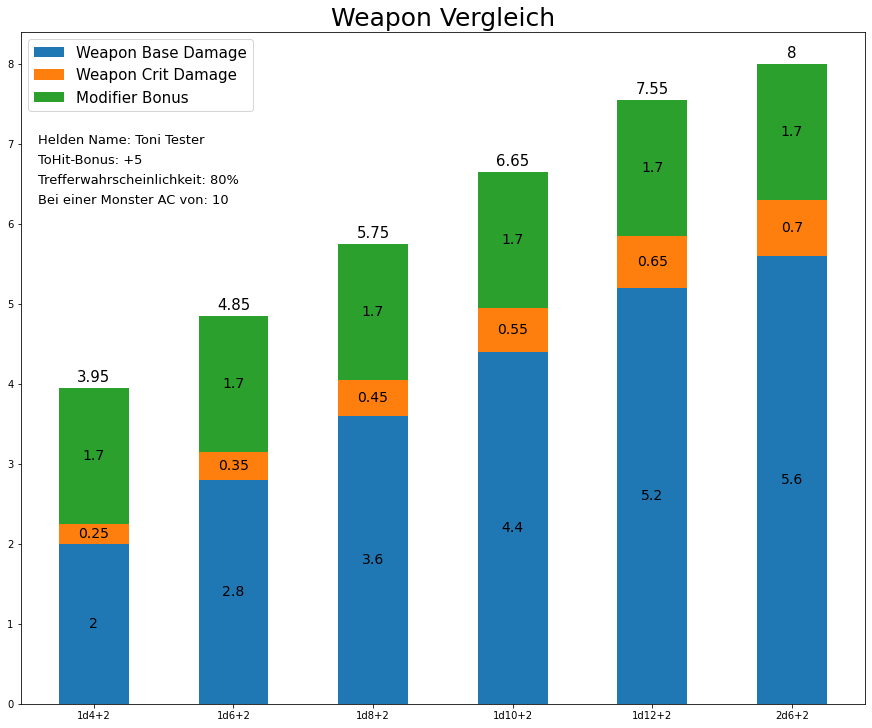

In [155]:
tester_toni.damageBonus = 2
weapon_damage_dict_base = {}
label_list = []

monsterAC = 10
textsize = 13


for weapon in weapon_dictionary:
    weapon_damage_dict_base[weapon] = tester_toni.damageCalculator(monsterAC, weapon_dictionary[weapon][1], weapon_dictionary[weapon][0])
    label_list.append(f"{weapon_dictionary[weapon][0]}{weapon_dictionary[weapon][1].name}{tester_toni.damageBonus:+}")
weapon_damage_dict_base
fig, ax, pDict = stacked_bar_plot_from_dict(weapon_damage_dict_base, "Weapon Vergleich")
ax.text(-0.4,7.0,s=f"Helden Name: {tester_toni.name}", fontdict={"size":textsize})
ax.text(-0.4,6.75,s=f"ToHit-Bonus: {tester_toni.toHitBonus:+}", fontdict={"size":textsize})
ax.text(-0.4,6.5,s=f"Trefferwahrscheinlichkeit: {weapon_damage_dict_base['1d4'][3]:.0%}", fontdict={"size":textsize})
ax.text(-0.4,6.25,s=f"Bei einer Monster AC von: {monsterAC}", fontdict={"size":textsize})
ax.set_xticks([0, 1, 2,3,4,5])
ax.set_xticklabels(label_list)

plt.show()

# Was ist besser? Ein +2 Schwert, oder Flame Tongue Sword

Zum Vergleich stehen:
* Ein Flame Tongue Longsword mit zusätzlichen 2d6 fire damage
* Ein +2 Longsword

## Punkte zu bedenken
* Beide werden vom Spiel als "rare" eingestuft.
* 2d6 fire Damage sind im Schnitt 7 Punkte Damage
* Das +2 Schwert hat "nur" +2 - aber auch ein +2 auf to Hit
    * Kann das +2 to Hit für den Unterschied im Damage ausmachen?

#### Neue Heldenklasse

In [156]:
class Dice:
    def __init__(self, minRoll, maxRoll):
        self.name = "d{}".format(maxRoll)
        self.minRoll = minRoll
        self.maxRoll = maxRoll
        self.dice = np.arange(minRoll,maxRoll+1)
        self.diceMean = self.dice.mean()
        
    @property
    def dice(self):
        return self._dice
    @dice.setter
    def dice(self, value):
        self._dice = value
        self.diceMean = self.dice.mean()
   

In [157]:
class DamageSource:
    def __init__(self, name, staticBonus=None, damageDice=None, diceAmount=None):
        self.name = name
        self.is_static = False
        self._staticBonus = staticBonus
        self._damageDice = damageDice
        self._diceAmount = diceAmount

        if staticBonus != None:
            self.baseDamage = self.staticBonus
            self.is_static = True
        else:
            self.baseDamage = self.damageDice.diceMean*self.diceAmount

    @property
    def staticBonus(self):
        return self._staticBonus
    @staticBonus.setter
    def staticBonus(self, value):
        self._staticBonus = value
        self.baseDamage = self.staticBonus
        self.is_static = True
    @property
    def damageDice(self):
        return self._damageDice
    @damageDice.setter
    def damageDice(self, value):
        self._damageDice = value
        self.baseDamage = self.damageDice.diceMean*self.diceAmount
    @property
    def diceAmount(self):
        return self._diceAmount
    @diceAmount.setter
    def diceAmount(self, value):
        self._diceAmount = value
        self.baseDamage = self.damageDice.diceMean*self.diceAmount


In [158]:
class Hero:
    def __init__(self, name, toHitBonus, critOn=20, critMultiplier=2):
        # toHitBonus: z.B. Archery Fighting Style
        # critOn: change if e.g. Fighter/Champion
        self.name = name
        self.toHitBonus = toHitBonus
        self.critOn = critOn
        self.critMultiplier = critMultiplier

        self.damageSources = {} # stores different types of damage

    def calcCritDamage(self):
        for s in self.damageSources:
            if self.damageSources[s].is_static:                
                self.damageSources[s].critDamage = self.damageSources[s].baseDamage
            else:
                self.damageSources[s].critDamage = self.damageSources[s].baseDamage*self.critMultiplier
               
    def addDamageSource(self, source):
        self.damageSources[source.name] = source
        self.calcCritDamage()
    
    def calcToHitChance(self, monsterAC, checkAdvantage=False):
        toHitAC = monsterAC - self.toHitBonus
        if toHitAC < 2:
            toHitAC = 2
        if toHitAC > 19:
            toHitAC = 21
        if checkAdvantage:
            self.chance2Hit = 1 - ((toHitAC-1)/20)**2
            self.chance2Crit = 1-((self.critOn-1)/20)**2
        else:
            self.chance2Hit = 1 - (toHitAC-1)/20
            self.chance2Crit = 1-((self.critOn-1)/20)
            
    def damageCalculator(self):
        self.base_damage = {} # base Damage of each damage Source
        self.crit_damage = {} # crit Damage of each damage Source
        self.expected_damage = {} # expected Damage of each damage Source
        
        for s in self.damageSources:
            self.expected_damage[s] = self.damageSources[s].baseDamage*self.chance2Hit + self.damageSources[s].critDamage*self.chance2Crit
            self.base_damage[s] = self.damageSources[s].baseDamage
            self.crit_damage[s] = self.damageSources[s].critDamage
        
        self.heroValues = { # sums up damage types
            "Expected Damage":sum(self.expected_damage.values()),
            "Base Damage":sum(self.base_damage.values()),
            "Crit Damage":sum(self.crit_damage.values()),
            "Chance to Hit":self.chance2Hit,
            "Chance to Crit":self.chance2Crit
        }          
    
    def show_hero_stats(self, full=False):
        print(f"Helden Name: {self.name}")
        print(f"ToHit-Bonus: {self.toHitBonus:+}")
        print(f"Trefferwahrscheinlichkeit: {self.chance2Hit}")
        print(f"Zu erwartender Schaden: {sum(self.expected_damage.values()):.2f}")
        if full:
            print("-"*10)
            print("Detailaufschlüsselung:")
            for key in self.expected_damage:
                print(f"  * {key}")
                print(f"      Zu erwartender Schaden: {self.expected_damage[key]}")
                print(f"      Base Damage: {self.base_damage[key]}")
                print(f"      Crit Damage: {self.crit_damage[key]}")  
        
                      

In [159]:
plus2_toni = Hero("Toni Plus2", 2)
plus2_toni.addDamageSource(DamageSource("Longsword", damageDice=Dice(1,8), diceAmount=1))
plus2_toni.addDamageSource(DamageSource("Ability Modifier", staticBonus=3))
plus2_toni.addDamageSource(DamageSource("Sword Dmg Bonus", staticBonus=2))
plus2_toni.calcToHitChance(monsterAC=10)
plus2_toni.damageCalculator()
plus2_toni.show_hero_stats()
print("--------------------")
flameTongue_toni = Hero("Toni Flame Tongue", 0)
flameTongue_toni.addDamageSource(DamageSource("Longsword", damageDice=Dice(1,8), diceAmount=1))
flameTongue_toni.addDamageSource(DamageSource("Ability Modifier", staticBonus=3))
flameTongue_toni.addDamageSource(DamageSource("Flame Tongue", damageDice=Dice(1,6), diceAmount=2))
flameTongue_toni.calcToHitChance(monsterAC=10)
flameTongue_toni.damageCalculator()
flameTongue_toni.show_hero_stats()

Helden Name: Toni Plus2
ToHit-Bonus: +2
Trefferwahrscheinlichkeit: 0.65
Zu erwartender Schaden: 6.88
--------------------
Helden Name: Toni Flame Tongue
ToHit-Bonus: +0
Trefferwahrscheinlichkeit: 0.55
Zu erwartender Schaden: 9.28


## Zwischenfazit

Man sieht also einen deutlichen Unterschied von 2,4 Punkten bei einer durchschnittlichen Trefferwahrscheinlichkeit.

Aber wir haben noch nicht die erhöhte Trefferwahrscheinlichkeit überprüft.

Existiert ein Punkt, bei dem sich der Bonus auf toHit auszahlt?

## Zu erwartender Schaden nach AC

In [160]:
magicItem_DF = pd.DataFrame(index=list(range(2,23)) ,columns=["Flame Tongue", "+2 Sword"])
magicItem_DF.index.name = "Monster AC"
for ac in magicItem_DF.index:
    plus2_toni.calcToHitChance(monsterAC=ac)
    plus2_toni.damageCalculator()
    flameTongue_toni.calcToHitChance(monsterAC=ac)
    flameTongue_toni.damageCalculator()

    magicItem_DF.loc[ac] = [sum(flameTongue_toni.expected_damage.values()), sum(plus2_toni.expected_damage.values())]

magicItem_DF["Unterschied"] = magicItem_DF["Flame Tongue"]-magicItem_DF["+2 Sword"]

magicItem_DF.transpose()

Monster AC,2,3,4,5,6,7,8,9,10,11,...,13,14,15,16,17,18,19,20,21,22
Flame Tongue,15.075,14.35,13.625,12.9,12.175,11.45,10.725,10.0,9.275,8.55,...,7.1,6.375,5.65,4.925,4.2,3.475,2.75,1.3,1.3,1.3
+2 Sword,9.725,9.725,9.725,9.25,8.775,8.3,7.825,7.35,6.875,6.4,...,5.45,4.975,4.5,4.025,3.55,3.075,2.6,2.125,1.65,0.7
Unterschied,5.35,4.625,3.9,3.65,3.4,3.15,2.9,2.65,2.4,2.15,...,1.65,1.4,1.15,0.9,0.65,0.4,0.15,-0.825,-0.35,0.6


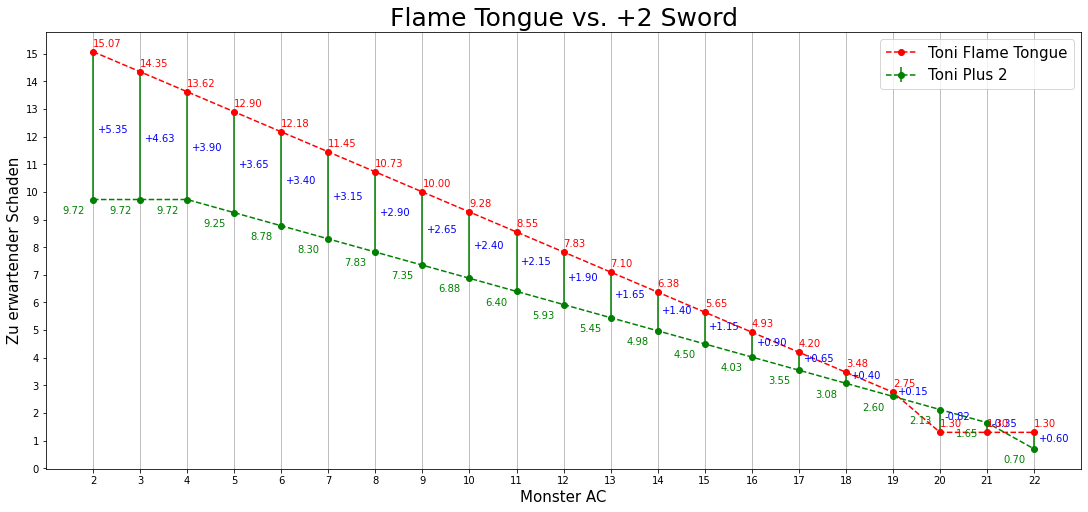

In [161]:
X = magicItem_DF.index
TICKSIZE = 15
TITLESIZE = 25

yerror = list(magicItem_DF["Flame Tongue"]-magicItem_DF["+2 Sword"])
fig, ax = plt.subplots(figsize=(15,7), layout="constrained")
ax.errorbar(X, y=magicItem_DF["+2 Sword"], yerr=[[0]*len(magicItem_DF.index),yerror], fmt="--go", label= "Toni Plus 2")
ax.plot(X, magicItem_DF["Flame Tongue"], "--ro", label= "Toni Flame Tongue")
for x,diff,plus2,ft in zip(X, magicItem_DF["Unterschied"], magicItem_DF["+2 Sword"], magicItem_DF["Flame Tongue"]):
    ax.annotate(text=f"{diff:+.2f}", xy=(x+0.1, plus2+diff*0.45)).set_color("b")
    ax.annotate(text=f"{plus2:.2f}", xy=(x-0.66, plus2-0.5)).set_color("g")
    ax.annotate(text=f"{ft:.2f}", xy=(x, ft+0.2)).set_color("r")
ax.grid(True, axis="x")
ax.set_xticks(ticks=X)
ax.set_yticks(ticks=range(16))
ax.set_xlabel("Monster AC", fontsize=TICKSIZE)
ax.set_ylabel("Zu erwartender Schaden", fontsize=TICKSIZE)
ax.set_title("Flame Tongue vs. +2 Sword", fontsize=TITLESIZE)
ax.legend(loc="best", fontsize=TICKSIZE)

plt.show()

# Advantage Disadvantage Auswertung

## Veränderte Trefferwahrscheinlichkeit

Bei Advantage wirft man zwei Würfel und nimmt das bessere Ergebnis.

Die Wahrscheinlichkeit mit Advantage zu treffen ist wieder 1 minus der Wahrscheinlichkeit, dass beide Würfe nicht treffen.

Z.B. toHit: +10, AC: 13 da würde 3 und höher treffen, bzw. 2 und 1 wären ein Misserfolg:
* Es gibt insgesamt 400 (20*20) mögliche Kombinationen.
* Davon sind nur 4 ein Misserfolg:
    * (1, 1) (1, 2) (2, 1), (2, 2)
* Daher ist die Wahrscheinlichkeit eines Misserfolgs 4/400, oder 1%
* Wieder im Umkehrschluss ist ein Wurf mit +10 toHit mit Advantage gegen eine AC 13 zu 99% erfolgreich

### Trefferwahrscheinlichkeit mit Disadvantage

Z.B. toHit: +1, AC: 20, eine 19 und 20 würden treffen:
Die Berechnung folgt demselben Prinzip: 
* Es gibt insgesamt 400 (20*20) mögliche Kombinationen.
* Davon sind nur 4 ein Erfolg:
    * (19, 19) (19, 20) (20, 19), (20, 20)
* Daher ist die Wahrscheinlichkeit eines Misserfolgs 396/400, oder 99%
* Im Umkehrschluss ist ein Wurf mit +1 toHit mit Disadvantage gegen eine AC 20 nur zu 1% erfolgreich

### Formalisierung der Trefferwahrscheinlichkeit

Für einen straight roll:
* $p = 1 - \frac{AC-toHit-1}{20}$

Für einen Treffer mit Advantage:
* $p = 1 -(\frac{AC-toHit-1}{20})^2$

Für einen Treffer mit Disadvantage:
* $p = (\frac{20-AC-toHit+1}{20})^2$

### Honorable Mention: Trip-Advantage
An dieser Stelle nur erwähnt, aber in weiterer Folge ignoriert, die Möglichkeit des Dreifach-Advantage. Erreicht z.B. über den Elven Accuracy Feat, oder dem Lucky Feat (wenn er in einer Advantage Situation angewendet wird)

Berechnung wie für Advantage, nur mit 3d20 (8.000 mögliche Kombinationen) - daher:
* $p = 1- (\frac{AC-toHit-1}{20})^3$

In [162]:
advDF = pd.DataFrame(index=list(range(2,21)))
advDF.index.name = "Benötigtes Ergebnis"

advDF["Trefferwahrscheinlichkeit"] = (1 - (advDF.index-1)/20)
advDF["mit Advantage"] = (1 - ((advDF.index-1)/20)**2)
advDF["mit Disadvantage"] = ((20-advDF.index+1)/20)**2

advDF["Unterschied zu Base"] = advDF["mit Advantage"] - advDF["Trefferwahrscheinlichkeit"]
# advDF["Dadv Unterschied zu Base"] = advDF["mit Disadvantage"] - advDF["Trefferwahrscheinlichkeit"]
advDF["Umrechnung statischer Bonus"] = advDF['Unterschied zu Base']*20 #(*100/5)
advDF

,Trefferwahrscheinlichkeit,mit Advantage,mit Disadvantage,Unterschied zu Base,Umrechnung statischer Bonus
Benötigtes Ergebnis,,,,,
2,0.95,0.9975,0.9025,0.0475,0.95
3,0.90,0.9900,0.8100,0.0900,1.80
4,0.85,0.9775,0.7225,0.1275,2.55
5,0.80,0.9600,0.6400,0.1600,3.20
6,0.75,0.9375,0.5625,0.1875,3.75
7,0.70,0.9100,0.4900,0.2100,4.20
8,0.65,0.8775,0.4225,0.2275,4.55
9,0.60,0.8400,0.3600,0.2400,4.80
10,0.55,0.7975,0.3025,0.2475,4.95


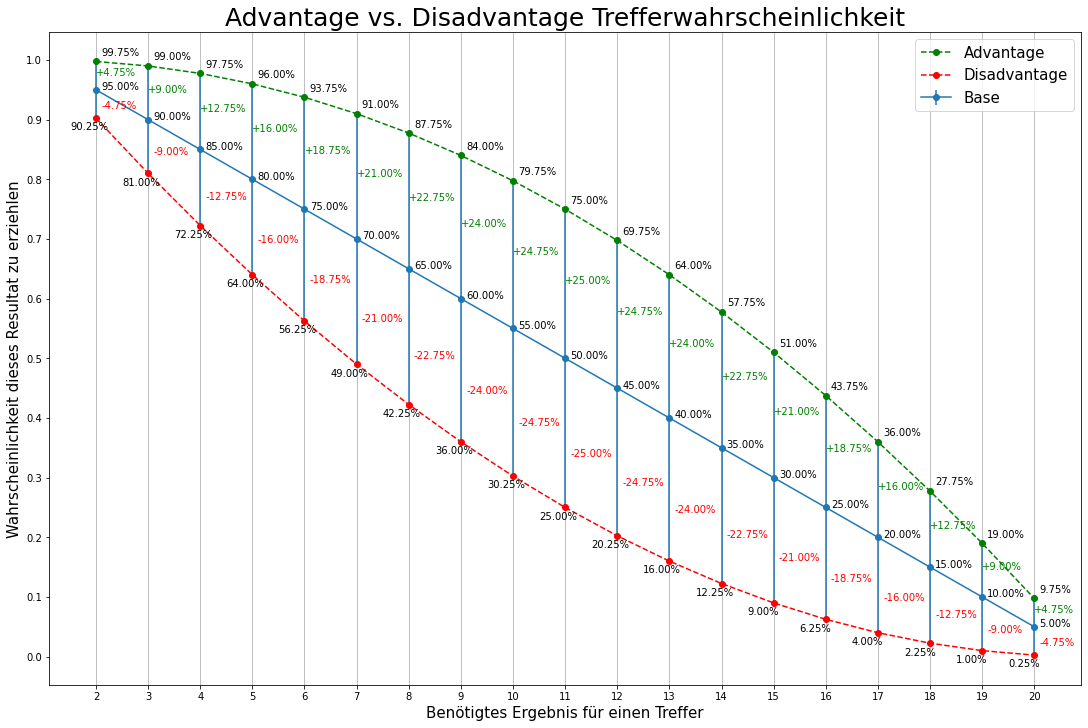

In [163]:
X = advDF.index
yerror = list(advDF["mit Advantage"]-advDF["Trefferwahrscheinlichkeit"])
fig, ax = plt.subplots(figsize=(15,10), layout="constrained")
ax.errorbar(X, y=advDF["Trefferwahrscheinlichkeit"], yerr=yerror, fmt="-o", label= "Base")
ax.plot(X, advDF["mit Advantage"], "--go", label= "Advantage")
ax.plot(X, advDF["mit Disadvantage"], "--ro", label= "Disadvantage")
for x,perc,adv,dadv,diff in zip(X, advDF["Trefferwahrscheinlichkeit"], advDF["mit Advantage"], advDF["mit Disadvantage"], advDF["Unterschied zu Base"]):
    ax.annotate(text=f"{perc:.2%}", xy=(x+0.1, perc))
    ax.annotate(text=f"{adv:.2%}", xy=(x+0.1, adv+0.01))
    ax.annotate(text=f"{dadv:.2%}", xy=(x-0.5, dadv-0.02))
    ax.annotate(text=f"{diff:+.2%}", xy=(x, perc+diff*0.5)).set_color("g")
    ax.annotate(text=f"-{diff:-.2%}", xy=(x+0.1, perc-diff*0.66)).set_color("r")
ax.grid(True, axis="x")
ax.set_xticks(ticks=X)
ax.set_yticks(ticks=np.linspace(0,1,11))
ax.set_xlabel("Benötigtes Ergebnis für einen Treffer", fontsize=TICKSIZE)
ax.set_ylabel("Wahrscheinlichkeit dieses Resultat zu erziehlen", fontsize=TICKSIZE)
ax.set_title("Advantage vs. Disadvantage Trefferwahrscheinlichkeit", fontsize=TITLESIZE)
ax.legend(loc="best", fontsize=TICKSIZE)


plt.show()

## Vergleich Der Auswirkung Advantage auf den Waffenschaden

# Analyse der Fighting Styles

## Archery
You gain a +2 bonus to attack rolls you make with ranged weapons.

## Dueling
When you are wielding a melee weapon in one hand and no other weapons, you gain a +2 bonus to damage rolls with that weapon.

## Great Weapon Fighting
When you roll a 1 or 2 on a damage die for an attack you make with a melee weapon that you are wielding with two hands, you can reroll the die and must use the new roll, even if the new roll is a 1 or a 2. The weapon must have the two-handed or versatile property for you to gain this benefit.

Die Idee des GWF ist, dass bei einer 1, oder 2 dieses Ergebnis mit einem neuen Wurf ersetzt wird.
* Unser Standard Array für einen d6 ist [1,2,3,4,5,6] = Durchschnitt = 3,5
* Wird bei einem GWF 1, oder 2 mit einem anderen Wurf ersetzt, wird 1, oder 2 mit dem durchschnitt des neuen Wurfs ersetzt
* Daher ist das angepasste Array: [3.5,3.5,3,4,5,6], Durchschnitt = 4,1667

## Two-Weapon Fighting
When you engage in two-weapon fighting, you can add your ability modifier to the damage of the second attack.

In [164]:
archery_toni = Hero("Toni Archer", 2)
archery_toni.addDamageSource(DamageSource("Longbow", damageDice=Dice(1,8), diceAmount=1))
archery_toni.addDamageSource(DamageSource("Ability Modifier", staticBonus=2))
archery_toni.calcToHitChance(monsterAC=10)
archery_toni.damageCalculator()
archery_toni.show_hero_stats(full=True)

Helden Name: Toni Archer
ToHit-Bonus: +2
Trefferwahrscheinlichkeit: 0.65
Zu erwartender Schaden: 4.78
----------
Detailaufschlüsselung:
  * Longbow
      Zu erwartender Schaden: 3.375000000000001
      Base Damage: 4.5
      Crit Damage: 9.0
  * Ability Modifier
      Zu erwartender Schaden: 1.4000000000000001
      Base Damage: 2
      Crit Damage: 2


In [165]:
dueling_toni = Hero("Toni Duelist", 0)
dueling_toni.addDamageSource(DamageSource("Longsword", damageDice=Dice(1,8), diceAmount=1))
dueling_toni.addDamageSource(DamageSource("Dueling FS", staticBonus=2))
dueling_toni.addDamageSource(DamageSource("Ability Modifier", staticBonus=2))
dueling_toni.calcToHitChance(monsterAC=10)
dueling_toni.damageCalculator()
dueling_toni.show_hero_stats(full=True)


Helden Name: Toni Duelist
ToHit-Bonus: +0
Trefferwahrscheinlichkeit: 0.55
Zu erwartender Schaden: 5.33
----------
Detailaufschlüsselung:
  * Longsword
      Zu erwartender Schaden: 2.9250000000000007
      Base Damage: 4.5
      Crit Damage: 9.0
  * Dueling FS
      Zu erwartender Schaden: 1.2000000000000002
      Base Damage: 2
      Crit Damage: 2
  * Ability Modifier
      Zu erwartender Schaden: 1.2000000000000002
      Base Damage: 2
      Crit Damage: 2


In [166]:
twoWeapon_toni = Hero("Toni Double Sword", 0)
twoWeapon_toni.addDamageSource(DamageSource("Shortsword", damageDice=Dice(1,6), diceAmount=1))
twoWeapon_toni.addDamageSource(DamageSource("Ability Modifier", staticBonus=2))
twoWeapon_toni.addDamageSource(DamageSource("Shortsword_offHand", damageDice=Dice(1,6), diceAmount=1))
twoWeapon_toni.addDamageSource(DamageSource("Ability Modifier_offHand", staticBonus=2))
twoWeapon_toni.calcToHitChance(monsterAC=10)
twoWeapon_toni.damageCalculator()
twoWeapon_toni.show_hero_stats(full=True)


Helden Name: Toni Double Sword
ToHit-Bonus: +0
Trefferwahrscheinlichkeit: 0.55
Zu erwartender Schaden: 6.95
----------
Detailaufschlüsselung:
  * Shortsword
      Zu erwartender Schaden: 2.2750000000000004
      Base Damage: 3.5
      Crit Damage: 7.0
  * Ability Modifier
      Zu erwartender Schaden: 1.2000000000000002
      Base Damage: 2
      Crit Damage: 2
  * Shortsword_offHand
      Zu erwartender Schaden: 2.2750000000000004
      Base Damage: 3.5
      Crit Damage: 7.0
  * Ability Modifier_offHand
      Zu erwartender Schaden: 1.2000000000000002
      Base Damage: 2
      Crit Damage: 2


In [167]:
gwf_toni = Hero("Toni Great Weapon", 0)

gwf_d6 = Dice(1,6)
gwf_d6.dice = np.array([3.5,3.5,3,4,5,6])

gwf_d10 = Dice(1,10)
gwf_d10.dice = np.array([5.5,5.5,3,4,5,6,7,8,9,10])

gwf_d12 = Dice(1,12)
gwf_d12.dice = np.array([6.5,6.5,3,4,5,6,7,8,9,10,11,12])

gwf_toni.addDamageSource(DamageSource("Greatsword", damageDice=gwf_d6, diceAmount=2))
gwf_toni.addDamageSource(DamageSource("Ability Modifier", staticBonus=2))
gwf_toni.calcToHitChance(monsterAC=10)
gwf_toni.damageCalculator()
gwf_toni.show_hero_stats(full=True)


Helden Name: Toni Great Weapon
ToHit-Bonus: +0
Trefferwahrscheinlichkeit: 0.55
Zu erwartender Schaden: 6.62
----------
Detailaufschlüsselung:
  * Greatsword
      Zu erwartender Schaden: 5.416666666666668
      Base Damage: 8.333333333333334
      Crit Damage: 16.666666666666668
  * Ability Modifier
      Zu erwartender Schaden: 1.2000000000000002
      Base Damage: 2
      Crit Damage: 2


In [168]:
def calculate_dmg_parts(value_array):
    exp_base_damage = value_array[1]*value_array[3] # BaseDamage * chance2Hit
    exp_crit_damage = value_array[2]*value_array[4] # CritDamage * chance2Crit
    return [exp_base_damage, exp_crit_damage]

def modify_data_4_plot(data_dictionary):
    exp_base_damages = []
    exp_crit_damages = []

    for value in data_dictionary:
        plot_data = calculate_dmg_parts(data_dictionary[value])
        exp_base_damages.append(plot_data[0])
        exp_crit_damages.append(plot_data[1])
    
    plot_dict = {
        "Expected Base Damage":exp_base_damages,
        "Expected Crit Damage":exp_crit_damages,
    }

    return plot_dict

def draw_stacked_bar_plot(plot_dict, labels, title):
    fig, ax = plt.subplots(figsize=(12,10), layout="constrained")
    bottom = np.zeros(len(labels))
    width = 0.5

    for dmgType, dmgValue in plot_dict.items():
        p = ax.bar(x=labels, height=dmgValue, width=width, label=dmgType, bottom=bottom)
        ax.bar_label(p, label_type="center", fontsize=TICKSIZE-1)
        bottom += dmgValue
    ax.bar_label(p, padding=3, fontsize=TICKSIZE)
    ax.set_title(f"{title}", fontsize=TITLESIZE)
    ax.legend(loc="upper left", fontsize=TICKSIZE)

    return fig, ax

def stacked_bar_plot_from_dict(data_dictionary, title):
    plot_dict = modify_data_4_plot(data_dictionary)
    fig, ax = draw_stacked_bar_plot(plot_dict, labels=list(data_dictionary.keys()), title=title)
    return fig, ax, plot_dict

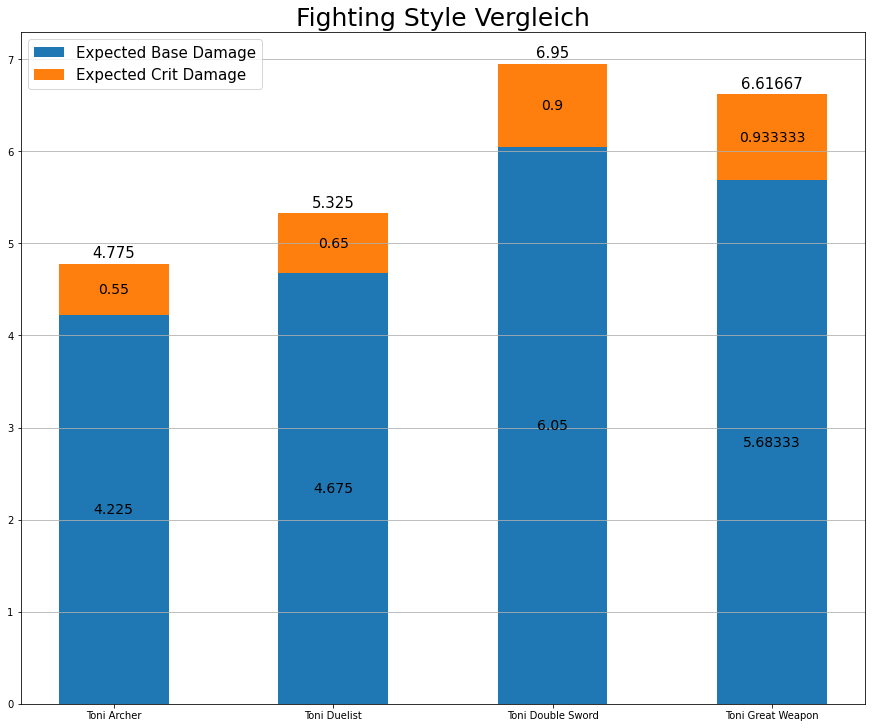

In [169]:
fs_testing_dict = {
    archery_toni.name:list(archery_toni.heroValues.values()),
    dueling_toni.name:list(dueling_toni.heroValues.values()),
    twoWeapon_toni.name:list(twoWeapon_toni.heroValues.values()),
    gwf_toni.name:list(gwf_toni.heroValues.values())
}

fig, ax, plot_dict = stacked_bar_plot_from_dict(fs_testing_dict, "Fighting Style Vergleich")
ax.grid(True, axis="y")


# ASI Auswirkungen

Welche unterschied macht eine Erhöhung eines Attributes auf den Schaden.

In [170]:
asi_toni = Hero("Toni Base", 0)
asi_toni.addDamageSource(DamageSource("Longsword", damageDice=Dice(1,8), diceAmount=1))
asi_toni.calcToHitChance(10)
asi_toni.damageCalculator()
asi_toni.show_hero_stats(full=True)

asi_toni_dmgIncrease = [asi_toni.heroValues["Expected Damage"]]

print("="*20)
asi_toni.name = "Toni ASI"
asi_toni.toHitBonus = 1
asi_toni.addDamageSource(DamageSource("Ability Modifier", staticBonus=1))
asi_toni.calcToHitChance(10)
asi_toni.damageCalculator()
asi_toni.show_hero_stats(full=True)

asi_toni_dmgIncrease.append(asi_toni.heroValues["Expected Damage"])

Helden Name: Toni Base
ToHit-Bonus: +0
Trefferwahrscheinlichkeit: 0.55
Zu erwartender Schaden: 2.93
----------
Detailaufschlüsselung:
  * Longsword
      Zu erwartender Schaden: 2.9250000000000007
      Base Damage: 4.5
      Crit Damage: 9.0
Helden Name: Toni ASI
ToHit-Bonus: +1
Trefferwahrscheinlichkeit: 0.6
Zu erwartender Schaden: 3.80
----------
Detailaufschlüsselung:
  * Longsword
      Zu erwartender Schaden: 3.1500000000000004
      Base Damage: 4.5
      Crit Damage: 9.0
  * Ability Modifier
      Zu erwartender Schaden: 0.65
      Base Damage: 1
      Crit Damage: 1


In [171]:
print(asi_toni_dmgIncrease[1]-asi_toni_dmgIncrease[0])

def calc_growth(old_value, new_value):
    return (new_value-old_value)/old_value

print(f"{calc_growth(asi_toni_dmgIncrease[0], asi_toni_dmgIncrease[1]):+.2%}")

0.8749999999999996
+29.91%


# Improved Critical (Fighter) vs. Brutal Critical (Barbarian)

## Fighter Champion Subclass
* Improved Critical
    * "Beginning when you choose this archetype at 3rd level, your weapon attacks score a critical hit on a roll of 19 or 20."
* Superior Critical 
    * Starting at 15th level, your weapon attacks score a critical hit on a roll of 18-20.

vgl. PHB S. 72

## Barbarian Brutal Critical
* "Beginning at 9th level, you can roll one additional weapon damage die when determining the extra damage for a critical hit with a melee attack. This increases to two additional dice at 13th level and three additional dice at 17th level."

vgl. PHB S. 46

Wir vergleichen eine erhöhte Wahrscheinlichkeit für einen Crit (10, bzw. 15%) mit einem erhöhten Schadensoutput bei einem Crit.

In [172]:
improCrit_toni = Hero("Toni Fighter", 0 ,critOn=19)
improCrit_toni.addDamageSource(DamageSource("Longsword", damageDice=Dice(1,8), diceAmount=1))
improCrit_toni.calcToHitChance(monsterAC=10)
improCrit_toni.damageCalculator()
improCrit_toni.show_hero_stats()
print(improCrit_toni.heroValues["Crit Damage"])
print("----------------------")
barbarian_toni = Hero("Toni Barbarian", 0, critMultiplier=3)
barbarian_toni.addDamageSource(DamageSource("Longsword", damageDice=Dice(1,8), diceAmount=1))
barbarian_toni.calcToHitChance(monsterAC=10)
barbarian_toni.damageCalculator()
barbarian_toni.show_hero_stats()
print(barbarian_toni.heroValues["Crit Damage"])

Helden Name: Toni Fighter
ToHit-Bonus: +0
Trefferwahrscheinlichkeit: 0.55
Zu erwartender Schaden: 3.38
9.0
----------------------
Helden Name: Toni Barbarian
ToHit-Bonus: +0
Trefferwahrscheinlichkeit: 0.55
Zu erwartender Schaden: 3.15
13.5


In [173]:
improCrit_toni = Hero("Toni Fighter", 0 ,critOn=19)
improCrit_toni.addDamageSource(DamageSource("Greatsword", damageDice=Dice(1,6), diceAmount=2))
improCrit_toni.calcToHitChance(monsterAC=10)
improCrit_toni.damageCalculator()
improCrit_toni.show_hero_stats()
print(improCrit_toni.heroValues["Crit Damage"])
print("----------------------")
barbarian_toni = Hero("Toni Barbarian", 0, critMultiplier=3)
barbarian_toni.addDamageSource(DamageSource("Greatsword", damageDice=Dice(1,6), diceAmount=2))
barbarian_toni.calcToHitChance(monsterAC=10)
barbarian_toni.damageCalculator()
barbarian_toni.show_hero_stats()
print(barbarian_toni.heroValues["Crit Damage"])

Helden Name: Toni Fighter
ToHit-Bonus: +0
Trefferwahrscheinlichkeit: 0.55
Zu erwartender Schaden: 5.25
14.0
----------------------
Helden Name: Toni Barbarian
ToHit-Bonus: +0
Trefferwahrscheinlichkeit: 0.55
Zu erwartender Schaden: 4.90
21.0


In [174]:
improCrit_toni = Hero("Toni Fighter", 0 ,critOn=19)
improCrit_toni.addDamageSource(DamageSource("Greataxe", damageDice=Dice(1,12), diceAmount=1))
improCrit_toni.calcToHitChance(monsterAC=10)
improCrit_toni.damageCalculator()
improCrit_toni.show_hero_stats(full=True)
print(improCrit_toni.heroValues["Crit Damage"])
print("----------------------")
barbarian_toni = Hero("Toni Barbarian", 0, critMultiplier=3)
barbarian_toni.addDamageSource(DamageSource("Greataxe", damageDice=Dice(1,12), diceAmount=1))
barbarian_toni.calcToHitChance(monsterAC=10)
barbarian_toni.damageCalculator()
barbarian_toni.show_hero_stats(full=True)
print(barbarian_toni.heroValues["Crit Damage"])

Helden Name: Toni Fighter
ToHit-Bonus: +0
Trefferwahrscheinlichkeit: 0.55
Zu erwartender Schaden: 4.88
----------
Detailaufschlüsselung:
  * Greataxe
      Zu erwartender Schaden: 4.875
      Base Damage: 6.5
      Crit Damage: 13.0
13.0
----------------------
Helden Name: Toni Barbarian
ToHit-Bonus: +0
Trefferwahrscheinlichkeit: 0.55
Zu erwartender Schaden: 4.55
----------
Detailaufschlüsselung:
  * Greataxe
      Zu erwartender Schaden: 4.550000000000001
      Base Damage: 6.5
      Crit Damage: 19.5
19.5


# Damage pro Level

## Fighter

## Barbarian

## Rogue

In [175]:
fighter_toni = Hero("Toni Fighter", 0)
barbarian_toni = Hero("Toni Barbarian", 0)
rogue_toni = Hero("Toni Rogue", 0)

monster_DF = pd.read_csv("monsterStats_DMGp274.csv").iloc[4:]

monsterAC = 10

fighter_toni.addDamageSource(DamageSource("Longsword", damageDice=Dice(1,8), diceAmount=1))
fighter_toni.addDamageSource(DamageSource("Ability Bonus", staticBonus=0))
fighter_toni.calcToHitChance(monsterAC)
fighter_toni.damageCalculator()     

expDMG_list = [(1, fighter_toni.heroValues["Expected Damage"], 0)] # (level, exp. Damage, growth)

i = 0

for lvl in [4,6,8,12,16]:
    print(fighter_toni.heroValues["Expected Damage"])

    # print(f"Level {lvl}")
    # monsterAC = monster_DF.loc[monster_DF["CR"]==lvl, "AC"].values[0]
    # print(f"Durchschnittliche Monster AC: {monsterAC}")
    fighter_toni.toHitBonus +=1
    fighter_toni.addDamageSource(DamageSource("Ability Bonus", staticBonus=i+1))
    # fighter_toni.damageSources["Ability Bonus"].staticBonus +=1
    # fighter_toni.calcCritDamage()
    fighter_toni.calcToHitChance(monsterAC)
    fighter_toni.damageCalculator()
    print(fighter_toni.chance2Hit)
    expDMG_list.append((lvl, fighter_toni.heroValues["Expected Damage"], calc_growth(old_value=expDMG_list[i][1], new_value=fighter_toni.heroValues["Expected Damage"])))
    i+=1

    fighter_toni.show_hero_stats(full=True)   
    print("="*20)


expDMG_list

2.9250000000000007
0.6
Helden Name: Toni Fighter
ToHit-Bonus: +1
Trefferwahrscheinlichkeit: 0.6
Zu erwartender Schaden: 3.80
----------
Detailaufschlüsselung:
  * Longsword
      Zu erwartender Schaden: 3.1500000000000004
      Base Damage: 4.5
      Crit Damage: 9.0
  * Ability Bonus
      Zu erwartender Schaden: 0.65
      Base Damage: 1
      Crit Damage: 1
3.8000000000000003
0.65
Helden Name: Toni Fighter
ToHit-Bonus: +2
Trefferwahrscheinlichkeit: 0.65
Zu erwartender Schaden: 4.78
----------
Detailaufschlüsselung:
  * Longsword
      Zu erwartender Schaden: 3.375000000000001
      Base Damage: 4.5
      Crit Damage: 9.0
  * Ability Bonus
      Zu erwartender Schaden: 1.4000000000000001
      Base Damage: 2
      Crit Damage: 2
4.775000000000001
0.7
Helden Name: Toni Fighter
ToHit-Bonus: +3
Trefferwahrscheinlichkeit: 0.7
Zu erwartender Schaden: 5.85
----------
Detailaufschlüsselung:
  * Longsword
      Zu erwartender Schaden: 3.6000000000000005
      Base Damage: 4.5
      Crit Dama

[(1, 2.9250000000000007, 0),
 (4, 3.8000000000000003, 0.2991452991452989),
 (6, 4.775000000000001, 0.2565789473684213),
 (8, 5.8500000000000005, 0.22513089005235581),
 (12, 7.025, 0.2008547008547008),
 (16, 8.3, 0.18149466192170824)]

# Was ist der durchschnittliche Gegner

# Literature

https://medium.com/@aking11/how-advantageous-is-advantage-in-d-d-5e-b0be28cb56a7
